In [71]:
import tensorflow as tf
from tensorflow.python.client import timeline

import numpy as np
import matplotlib.pyplot as plt
import h5py 
import scipy.io
import scipy as scipy


In [72]:
# Some helpful MATLAB functions
def abssqr(inputar):
    return np.real(inputar*np.conj(inputar))
    #return tf.abs(inp#utar)**2

def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)
    
def rr(inputsize_x=100, inputsize_y=100, inputsize_z=100, x_center=0, y_center = 0, z_center=0):
    x = np.arange(-inputsize_x/2,inputsize_x/2, 1)
    y = np.arange(-inputsize_y/2,inputsize_y/2, 1)
    if inputsize_z<=1:
        xx, yy = np.meshgrid(x+x_center, y+y_center)
        r = np.sqrt(xx**2+yy**2)
        r = np.transpose(r, [1, 0]) #???? why that?!
    else:
        z = np.arange(-inputsize_z/2,inputsize_z/2, 1)
        xx, yy, zz = np.meshgrid(x+x_center, y+y_center, z+z_center)
        xx, yy, zz = np.meshgrid(x, y, z)
        r = np.sqrt(xx**2+yy**2+zz**2)
        r = np.transpose(r, [1, 0, 2]) #???? why that?!
        
    return np.squeeze(r)

def xx(inputsize_x=128, inputsize_y=128, inputsize_z=1):
    x = np.arange(-inputsize_x/2,inputsize_x/2, 1)
    y = np.arange(-inputsize_y/2,inputsize_y/2, 1)
    if inputsize_z<=1:
        xx, yy = np.meshgrid(x, y)
        xx = np.transpose(xx, [1, 0]) #???? why that?!
    else:
        z = np.arange(-inputsize_z/2,inputsize_z/2, 1)
        xx, yy, zz = np.meshgrid(x, y, z)
        xx = np.transpose(xx, [1, 0, 2]) #???? why that?!
    return np.squeeze(xx)

def yy(inputsize_x=128, inputsize_y=128, inputsize_z=1):
    x = np.arange(-inputsize_x/2,inputsize_x/2, 1)
    y = np.arange(-inputsize_y/2,inputsize_y/2, 1)
    if inputsize_z<=1:
        xx, yy = np.meshgrid(x, y)
        yy = np.transpose(yy, [1, 0]) #???? why that?!
    else:
        z = np.arange(-inputsize_z/2,inputsize_z/2, 1)
        xx, yy, zz = np.meshgrid(x, y, z)
        yy = np.transpose(yy, [1, 0, 2]) #???? why that?!
    return np.squeeze(yy)

def zz(inputsize_x=128, inputsize_y=128, inputsize_z=1):
    nx = np.arange(-inputsize_x/2,inputsize_x/2, 1)
    ny = np.arange(-inputsize_y/2,inputsize_y/2, 1)
    nz = np.arange(-inputsize_z/2,inputsize_z/2, 1)
    xxr, yyr, zzr = np.meshgrid(nx, ny, nz)
    zzr = np.transpose(zzr, [1, 0, 2]) #???? why that?!
    return (zzr)

def my_ft3d_np(numpy):
    """
    fftshift(fft(ifftshift(a)))
    
    Applies shifts to work with arrays whose "zero" is in the middle 
    instead of the first element.
    
    Uses standard normalization of fft unlike dip_image.
    """
    return np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(numpy)))

def my_ift3d_np(numpy):
    """
    fftshift(ifft(ifftshift(a)))
    
    Applies shifts to work with arrays whose "zero" is in the middle 
    instead of the first element.
    
    Uses standard normalization of fft unlike dip_image.
    """
    return np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(numpy)))


def insertSrc(mysize,myWidth=20,myOff=None, kx=0, ky=0):
    '''
    % mysample=insertSrc(mysample,myWidth,myOff,kx) : inserts a Gaussian source bar for the SEAGLE simulation
    % mysample : refractive indext to insert into
    % myWidth : Gaussian width
    % myOff : 2-component vector for position
    % kx : determins angle of emission (default 0)
    '''
    
    
    if myOff == None:
        myOff=((101, np.floor((mysample.shape[1],2)/2)))

    mySrc = np.zeros(mysize)+1j*np.zeros(mysize)
    myOffX=myOff[0]
    myOffY=myOff[1]

    if np.size(mysize) > 2:
        myOffZ=myOff[2]
        print("WARNING: Not yet implemented")
        mySrc[myOffX,:,:] = np.exp(1j*kx * (myOffY+yy(1,mysize[1],mysize[2]))) * np.exp(-abssqr(((myOffY+yy(1,mysize[1],mysize[2]))))/(2*myWidth**2))
        mySrc[myOffX,:,:] = mySrc[myOffX,:,:] * np.exp(1j*ky * (myOffZ+zz(1,mysize[1],mysize[2]))) * np.exp(-abssqr(((myOffZ+zz(1,mysize[1],mysize[2]))))/(2*myWidth**2))
    else:

        mySrc[myOffX,:] = np.exp(1j*kx * (myOffY+yy(1,mysize[1]))) * np.exp(- abssqr(myOffY+yy(1,mysize[1]))/(2*myWidth**2))
        
    return mySrc




def insertPerfectAbsorber(mysample,SlabX,SlabW=1,direction=None,k0=None,N=4):
    '''
    % mysample=insertPerfectAbsorber(mysample,SlabX,SlabW) : inserts a slab of refractive index material into a dataset
    % mysample : dataset to insert into
    % SlabX : middle coordinate
    % SlabW : half the width of slab
    % direction : direction of absorber: 1= left to right, -1=right to left, 2:top to bottom, -2: bottom to top
    '''

    if k0==None:
        k0=0.25/np.max(np.real(mysample));

    k02 = k0**2;
    
    if mysample.ndim < 3:
        mysample = np.expand_dims(mysample, 2)
        
        
    myXX=xx(mysample.shape[0], mysample.shape[1], mysample.shape[2])+mysample.shape[0]/2
    
    if np.abs(direction) <= 1:
        myXX=xx(mysample.shape[0], mysample.shape[1], mysample.shape[2])+mysample.shape[0]/2
    elif np.abs(direction) <= 2:
        myXX=yy(mysample.shape[0], mysample.shape[1], mysample.shape[2])+mysample.shape[1]/2
    elif np.abs(direction) <= 3:
        myXX=zz(mysample.shape[0], mysample.shape[1], mysample.shape[2])+mysample.shape[1]/2


    alpha=0.035*100/SlabW #; % 100 slices
    if direction > 0:
        #% mysample(abs(myXX-SlabX)<=SlabW)=1.0+1i*alpha*exp(xx(mysize,'corner')/mysize(1));  % increasing absorbtion
        myX=myXX-SlabX
    else:
        # %mysample(abs(myXX-SlabX)<=SlabW)=1.0+1i*alpha*exp((mysize(1)-1-xx(mysize,'corner'))/mysize(1));  % increasing absorbtion
        myX=SlabX+SlabW-myXX-1
        
        
    myMask= (myX>=0) * (myX<SlabW)

    alphaX=alpha*myX[myMask]
    
    PN=0;
    for n in range(0, N+1):
        PN = PN + np.power(alphaX,n)/factorial(n)

    k2mk02 = np.power(alphaX,N-1)*abssqr(alpha)*(N-alphaX + 2*1j*k0*myX[myMask])/(PN*factorial(N))
    
 
    mysample[myMask] = np.sqrt((k2mk02+k02)/k02)
            
    #np.array(mysample)[0]
    
    return mysample,k0


def insertSphere(obj_shape = [100, 100, 100], obj_dim = 0.1, obj_type = 0, diameter = 1, dn = 0.1):
    ''' Function to generate a 3D RI distribution to give an artificial sample for testing the FWD system
    INPUTS:
        obj_shape - Nx, Ny, Nz e.g. [100, 100, 100]
        obj_dim - sampling in dx/dy/dz 0.1 (isotropic for now)
        obj_type - 0; One Sphere 
                 - 1; Two Spheres 
                 - 2; Two Spheres 
                 - 3; Two Spheres inside volume
                 - 4; Shepp Logan Phantom (precomputed in MATLAB 120x120x120 dim)
        diameter - 1 (parameter for diameter of sphere)
        dn - difference of RI e.g. 0.1
        
    OUTPUTS: 
        f - 3D RI distribution
            
    '''
    # one spherical object inside a volume
    f = (dn)*(rr(obj_shape[0], obj_shape[1], obj_shape[2])*obj_dim < diameter)
    return f
    

# Lets define the SEAGLE forward model according to the formula in the paper

Basically we want to invert the Lippmann Schwinger equation:

     
$$u(x) = u_{in}+\int_{-\infty}^{\infty} g(x-x^´) f(x^´) u(x^´) \, dx^´$$



Which is equal to a convolution with the Greensfunction with the scattering potential. The Greensfunction in 3D is 
$$ g(x) = \frac{exp(j k_b ||x||^2)}{4\pi||x||^2)} $$ 

where $k_b=\frac{2\pi}{\lambda_0}\sqrt{n_{embb}}$ is the wavenumber in the background medium.


It further reduces to:
$$u(x) = u_{in}+u_{scat}$$

where
$$u_{scat}=\int_{-\infty}^{\infty} g(x-x^´) f(x^´) u(x^´) \, dx^´$$


We can now write the above equation as:


$$u(x) = u_{in}+{F}^{-1}\{{F}\{G\}\times {F}\{f\times u\}\}$$
where $$F\{\},F^{-1}\{\}$$ denote the 3D Fourier- and inverse 3D Fourier-transform respectively. 
We now assume, that the input field $u_{in}$ is known and try to minimize the following problem with respect to $u$:

$$min_{\rightarrow u} \left( u(x) - u_{in} - {F}^{-1}\{{F}\{G\}\times {F}\{f\times u\}\}\right)$$


As an object $f(x)$ we insert the 3D refractive index distribution as follows:

$$f(x) = k^2(n_{obj}(x)-n_{embbb})$$
which is assumed to be real, where the wavenumber in vacuum is given by $k=\frac{2 \pi }{\lambda_0}$.

# Here the actual programm starts - Define the Parameters

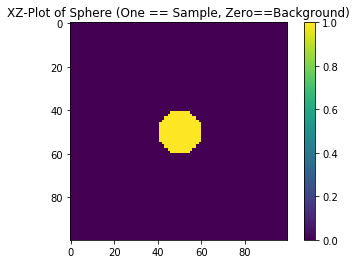

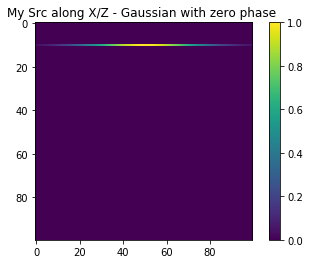

(<matplotlib.image.AxesImage at 0x10a1b77f0>,
 None)

In [73]:
# Define some parameters
is_debug = False # do you want to display everything?
mysize = (100, 100, 100) # X Y Z
mymidpoint = int(mysize[1]/2)

# Sample preferences
mysample = np.zeros(mysize)
nObj = 1.45
nEmbb = 1.33
Boundary=9;
# generate Sample, Assume nObj everywhere where mysample is 1, rest is background 
mysample = insertSphere((mysample.shape[0], mysample.shape[1], mysample.shape[2]), obj_dim=0.1, obj_type=0, diameter=1, dn=1) 

#nObj = 1.52 + 0.0 * 1j;
plt.title('XZ-Plot of Sphere (One == Sample, Zero==Background)')
plt.imshow(np.real(mysample[:,mymidpoint,:])), plt.colorbar(), plt.show()

# Experimental Parameters
lambda0 = .5; # measured in µm
pixelsize = lambda0/4 # measured in µm

# define the source and insert it in the volume
kx = 0
ky = 0
myWidth = 20;
mySrc = insertSrc(mysize, myWidth, myOff=(Boundary+1, 0, 0), kx=kx,ky=ky);
plt.title('My Src along X/Z - Gaussian with zero phase ')
plt.imshow(np.squeeze(np.real(mySrc[:,:,np.int(np.floor(mysize[2]/2))]))), plt.colorbar(), plt.show()


# Lets convert the binary sample (1/0) into a physical relevant object

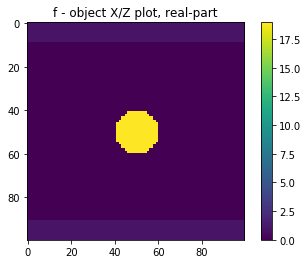

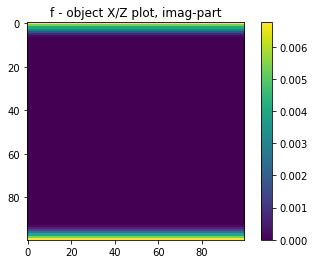

(<matplotlib.image.AxesImage at 0x126faee10>,
 None)

In [74]:
# Compute wave-number in medium
k0 = 2*np.pi/lambda0;
kb = 2*np.pi/lambda0*(nEmbb);
k02 = k0**2
kr=(pixelsize)*rr(mysize[0], mysize[1], mysize[2])

# compile the object into the real-world (how much phase retardation)
f = (k02)*mysample*(nObj-nEmbb)+0j

# We need to insert the perfect-aborber boundeary condition allong to prevent reflection at th edges
if(Boundary>0):
    f, _ = insertPerfectAbsorber(f, 0, Boundary, -1, k0);
    f, _ = insertPerfectAbsorber(f, f.shape[0] - Boundary, Boundary, 1, k0);

plt.title('f - object X/Z plot, real-part')
plt.imshow(np.real(f[:,mymidpoint,:])), plt.colorbar(), plt.show()

plt.title('f - object X/Z plot, imag-part')
plt.imshow(np.imag(f[:,mymidpoint,:])), plt.colorbar(), plt.show()



The above sample doesn't make much sense but follows the formula from SEAGLE. What's wrong? Do I need to incorporate the pixelsize somewhere? 

# Here we compute the Greensfunction 
There might be a sampling problem. Need to check if the coordinates are working correctly!

Now computing Greens function and its fourier transformed
# What is the correct factor and why?


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


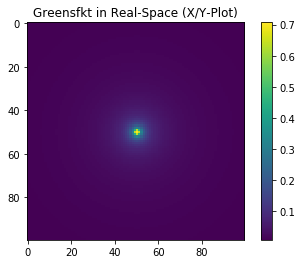

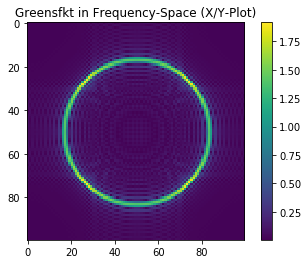

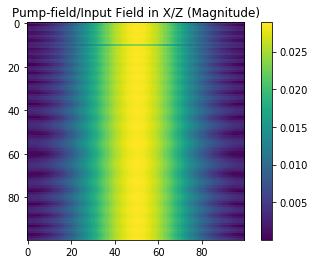

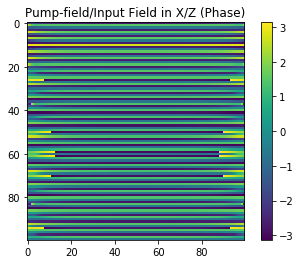

(Text(0.5, 1.0, 'Pump-field/Input Field in X/Z (Phase)'),
 None)

In [75]:
#%---------------------------------------------------------------------
#                  START CODE HERE                                    #
#%---------------------------------------------------------------------

# First we need to pad our volume to get rid of reflection/wrap arounds
if(False):
    # will take care of this later
    mysample = extract3D(mysample, newsize = mysize_new)
    mySrc = extract3D(mySrc, newsize = mysize_new)
    myMask = extract3D(np.ones(mySrc.shape), newsize = mysize_new)>.5

# Compute Greensfunction
print('Now computing Greens function and its fourier transformed')
greens_fkt = np.exp((1j*kb)*np.abs(kr))/np.abs(4*np.pi*kr)

#greens_fkt = np.exp((1j*2*np.pi)*mykr) / np.abs(2*np.pi*mykr)
mycenter = [int(mysize[0]/2), int(mysize[1]/2), int(mysize[2]/2)]
greens_fkt[mycenter[0], mycenter[1], mycenter[2]]=1.0/np.sqrt(2) # Normalize, Make sure to not divide by zero

# Compute Green's Function in Frequency Space
Fac=.015;  # What is the correct factor and why?
print('# What is the correct factor and why?')
greens_fkt_ft = my_ft3d_np(greens_fkt * Fac)

# Visualize Greenzs function
plt.title('Greensfkt in Real-Space (X/Y-Plot)'), plt.imshow(np.abs(greens_fkt[:,:,mymidpoint])), plt.colorbar(), plt.show()
plt.title('Greensfkt in Frequency-Space (X/Y-Plot)'), plt.imshow(np.abs(greens_fkt_ft[:,:,mymidpoint])), plt.colorbar(), plt.show()


# Compute the pump field inside the volume
u_in = my_ift3d_np(my_ft3d_np(mySrc) * greens_fkt_ft)
plt.title('Pump-field/Input Field in X/Z (Magnitude)'), plt.imshow(np.abs(u_in[:,:,mymidpoint])), plt.colorbar(), plt.show()
plt.title('Pump-field/Input Field in X/Z (Phase)'), plt.imshow(np.angle(u_in[:,:,mymidpoint])), plt.colorbar(), plt.show()



Ok, there is definitely something completely wrong. Why do I need this weird normalization factor? Dividing by there is ok..but should be only one pixel.. Is anyway filtered out by setting it to 1/sqrt(2)..not? 

# Define the FWD Model according to the formulas above

In [76]:
# perform one step in the iteration of SEAGLE
# it computes   u' = (I - G diag(f))*u - u_in, which gives u_in in Lippmann-Schwinger equation
# altenatively: u' = u - G (*) (u*f) - u_in, which gives u_in in Lippmann-Schwinger equation
# compute FT(f*u)

print("Assum u is our Variable which we want to optimize in the end. It represents the field inside the Volume")
print("In a naiv first approach we assign the input field u_in in u")
u = u_in
if(True):
    u_f = my_ift3d_np(f*u)
else:
    u_f = my_ift3d_np((1j*(self.tf_f_obj - 1.0)*2*np.pi*self.k0)*self.tf_u) # 2 pi circumference corresponds to one lambda. One pixels is k0 * lambda

    
# convolve with G and add the input field
# 0 = u - conv(G, f*u) - u_in
u_d = u - my_ift3d_np(greens_fkt_ft * u_f) - u_in 

# In order to get tf_u_d we need to minimize self.tf_u_d 
# 1/2 * ||Au - uin||^2_2
my_error = 1/2*abssqr(u_d)

# Now minimize my_error with respect to u


Assum u is our Variable which we want to optimize in the end. It represents the field inside the Volume
In a naiv first approach we assign the input field u_in in u


# Results from Tensorflow minimization with ADAM and lr=0.01

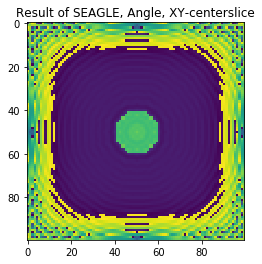

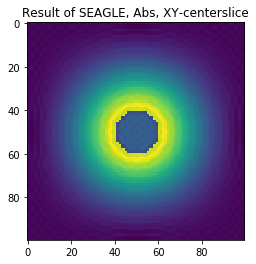

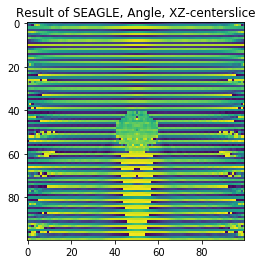

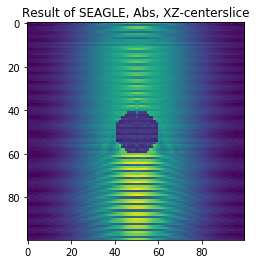

(Text(0.5, 1.0, 'Result of SEAGLE, Abs, XZ-centerslice'),
 None)

In [77]:
plt.title('Result of SEAGLE, Angle, XY-centerslice'), plt.imshow(plt.imread('result_angle_xy.png')), plt.show()
plt.title('Result of SEAGLE, Abs, XY-centerslice'), plt.imshow(plt.imread('result_abs_xy.png')), plt.show()
plt.title('Result of SEAGLE, Angle, XZ-centerslice'), plt.imshow(plt.imread('result_angle_xz.png')), plt.show()
plt.title('Result of SEAGLE, Abs, XZ-centerslice'), plt.imshow(plt.imread('result_abs_xz.png')), plt.show()